<a href="https://colab.research.google.com/github/megha-puthukudi/main-project/blob/VGG19-SPOT/vecicle_spot_position_VGG19_epoch_150_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 1042 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 215 images belonging to 3 classes.
Epoch 1/150
32/32 [==============================] - 21s 591ms/step - loss: 1.4884 - accuracy: 0.3733 - val_loss: 1.0818 - val_accuracy: 0.4866
Epoch 2/150
32/32 [==============================] - 18s 569ms/step - loss: 1.0777 - accuracy: 0.3931 - val_loss: 1.0646 - val_accuracy: 0.4688
Epoch 3/150
32/32 [==============================] - 19s 595ms/step - loss: 1.0616 - accuracy: 0.4139 - val_loss: 1.0253 - val_accuracy: 0.5134
Epoch 4/150
32/32 [==============================] - 19s 593ms/step - loss: 1.0487 - accuracy: 0.4376 - val_loss: 1.0223 - val_accuracy: 0.5268
Epoch 5/150
32/32 [==============================] - 20s 613ms/step - loss: 1.0345 - accuracy: 0.4703 - val_loss: 0.9522 - val_accuracy: 0.6205
Epoch 6/150
32/32 [==============================] - 19s 577ms/step - loss: 0.9555 - accuracy: 0.5584 - val_loss: 0.8111 - val_accuracy: 0.6518
Epoch 7/150


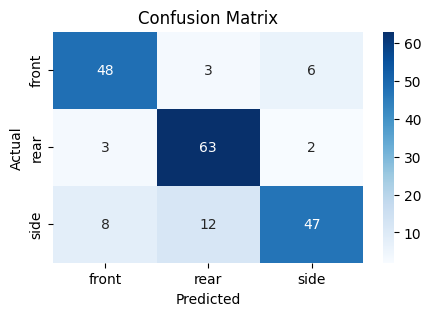

Test loss: 2.6072
Test accuracy: 80.73
Train loss: 0.0717
Train accuracy: 96.88
Recall: 0.82
Precision: 0.83
F1-score: 0.82


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns  # Added seaborn for visualization

# Define your data directories
train_dir = '/content/drive/MyDrive/dataset for spot/train'
val_dir = '/content/drive/MyDrive/dataset for spot/validation'
test_dir = '/content/drive/MyDrive/dataset for spot/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 32  # Increase batch size for faster convergence

# Create data generators with more aggressive data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add dropout for regularization
x = Dropout(0.5)(x)

# Add a dense output layer with softmax activation
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model except the last few
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00008), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=150,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['front', 'rear', 'side'], yticklabels=['front', 'rear', 'side'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_spot_position_VGG19_epoch_150_dataset.h5')


Saving assa.jpeg to assa.jpeg
1/1 [==============================] - 0s 153ms/step


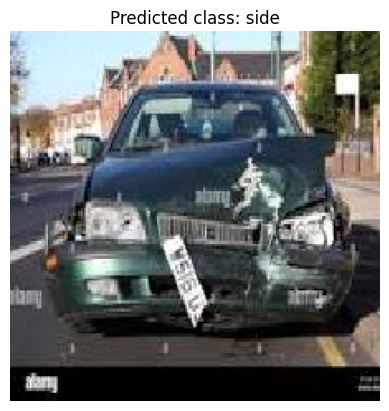

In [6]:
# Prediction section of car is damaged or Not damaged
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

# Load the trained model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/colabtest/vecicle_spot_position_VGG19_epoch_150_dataset.h5')

# Define your class labels
class_labels = ['front', 'rear', 'side']

def predict_image(file_path):
    # Load the image from the specified file path and resize it to the target size of (224, 224)
    img = image.load_img(file_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the input image using the preprocess_input function (specific to the model)
    processed_img = preprocess_input(img_array)
    # Use the loaded model to predict the class probabilities for the preprocessed image
    prediction = loaded_model.predict(processed_img)
    # Find the index of the class with the highest probability
    predicted_class_index = np.argmax(prediction)
    # Retrieve the corresponding class label from the class_labels list
    predicted_class_label = class_labels[predicted_class_index]

    return predicted_class_label, img

def select_image_and_predict():
    uploaded = files.upload()

    if uploaded:
        # Get the file path of the uploaded image
        file_path = list(uploaded.keys())[0]
        predicted_class, img = predict_image(file_path)    # Predict the class label and get the image
        plt.imshow(img)     # Display the image
        plt.axis('off')    # Turn off axis in the displayed image
        plt.title(f"Predicted class: {predicted_class}")
        plt.show()    # Show the plot with the image and title
    else:
        print("No file selected.")

# Call the function to select an image and make a prediction
select_image_and_predict()